<a href="https://colab.research.google.com/github/thisaraniNJ/MachineLearning_CW/blob/main/MachineLearningCW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


**Load the Dataset**


In [2]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML CW/bank-additional-full.csv', delimiter=";")

In [3]:
# Display the initial dataset structure
print("Dataset Overview: ")
print(df.info())

Dataset Overview: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.id

In [4]:
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.co

**Encode Categorical Variables**

In [5]:
# Encode the target variable ('y') to binary (yes: 1, no: 0)
df['y'] = df['y'].map({
    'yes': 1,
    'no':0
})

In [6]:
# Identify categorical columns
categorical_columns =[
    "job", "marital", "education", "default", "housing", "loan",
    "contact", "month", "day_of_week", "poutcome"
]

In [7]:
# Encode categorical columns using LabelEncoder
encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

**Handle Missing Values**

In [8]:
# Check for missing values
print("\nMissing values in the dataset: ")
print(df.isnull().sum())


Missing values in the dataset: 
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


**Feature Scaling**

In [9]:
# Identify numerical columns
numerical_columns = [
    "age", "duration", "campaign", "pdays", "previous",
    "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
]

In [10]:
# Scale numerical columns using StandardScaler
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

**Handle Class Imbalance**

In [11]:
# Separate features and target variable
X = df.drop('y', axis=1)
y = df['y']

In [12]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

**Test - Train Split**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

In [14]:
# Display summary of the prepared dataset
print("\nTraining Dataset (X_train) Shape:", X_train.shape)
print("Test Dataset (X_test) Shape:", X_test.shape)
print("Training Target (y_train) Distribution:")
print(y_train.value_counts())
print("\nTest Target (y_test) Distribution:")
print(y_test.value_counts())


Training Dataset (X_train) Shape: (51167, 20)
Test Dataset (X_test) Shape: (21929, 20)
Training Target (y_train) Distribution:
y
1    25584
0    25583
Name: count, dtype: int64

Test Target (y_test) Distribution:
y
0    10965
1    10964
Name: count, dtype: int64


# Neural Network Model

Import necessary libraries

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Define the Neural Network Model

In [23]:
# Define the Neural Network Model
def build_nn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  # Define the input shape explicitly
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [24]:
# Initialize the model
input_dim = X_train.shape[1]  # Number of features
nn_model = build_nn_model(input_dim)

In [25]:
# Display model summary
print("\nNeural Network Model Summary:")
nn_model.summary()


Neural Network Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

Train the Neural Network Model

In [26]:
batch_size = 32
epochs = 20

history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8307 - loss: 0.3880 - val_accuracy: 0.8853 - val_loss: 0.2802
Epoch 2/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8854 - loss: 0.2881 - val_accuracy: 0.8917 - val_loss: 0.2659
Epoch 3/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8898 - loss: 0.2765 - val_accuracy: 0.8958 - val_loss: 0.2577
Epoch 4/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8936 - loss: 0.2655 - val_accuracy: 0.8989 - val_loss: 0.2500
Epoch 5/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8976 - loss: 0.2578 - val_accuracy: 0.9000 - val_loss: 0.2483
Epoch 6/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9024 - loss: 0.2497 - val_accuracy: 0.9015 - val_loss: 0.2458
Epoch 7/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9043 - loss: 0.2436 - val_accuracy: 0.9039 - val_loss: 0.2402
Epoch 8/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9039 - loss: 0.2422 - 

Evaluate the Neural Network Model

In [27]:
print("\nEvaluating the Neural Network Model on Test Data:")
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating the Neural Network Model on Test Data:
Test Loss: 0.2231
Test Accuracy: 0.9127


Generate Preditions and Metrics

In [30]:
y_pred = (nn_model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report for Neural Network:")
print(classification_report(y_test, y_pred))

686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     10965
           1       0.88      0.95      0.92     10964

    accuracy                           0.91     21929
   macro avg       0.92      0.91      0.91     21929
weighted avg       0.92      0.91      0.91     21929



Visualize Training History

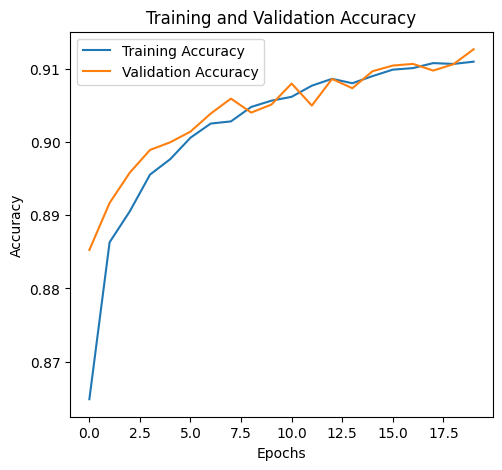

In [31]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


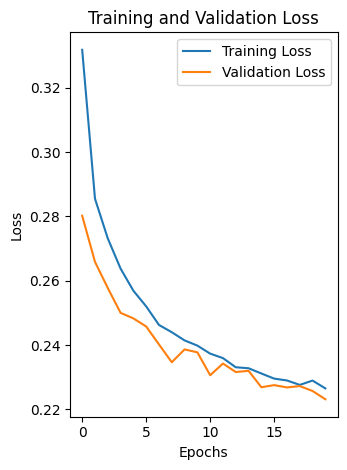

In [34]:
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()